Prep

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy.random as npr

from tensorflow.keras.layers import Layer, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from skimage.restoration import denoise_wavelet
from collections import OrderedDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Original Model
vgg = VGG19()

574717952/574710816 [==============================] - 10s 0us/step


Function to split the model into blocks

In [ ]:
def split_model(inmodel, names):
  #Splits model right before each of the layers in names
  #Returns a list of the split models. 
  models = []
  models.append(Sequential())

  i = 0
  out_size = None
  #Adds costum layer before layer names
  for jj, layer in enumerate(inmodel.layers):
    if layer.name in names:
      out_size = inmodel.layers[jj-1].output.shape[1:]
      models.append(Sequential())
      i +=1 
      models[i].add(InputLayer(out_size))
          
    models[i].add(layer)
    
  return models

In [ ]:
#List out the vgg layer names, so it is easier for us to choose
vgg_names = []
for layer in vgg.layers:
  vgg_names.append(layer.name)

#Selecting layers
# nums = [17]
# insert_layers = [vgg_names[i] for i in nums]
# insert_layers

In [ ]:
#model_insert_positions= [[], [1], [4], [7], [12], [17]]
model_insert_positions= [[],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],
                         [13],[14],[15],[16],[17],[18],[19],[20],[21]]
model_insert_names = []
for positions in model_insert_positions:
  model_insert_names.append([vgg_names[i] for i in positions])
models_list = []
for lst in model_insert_names:
  models_list.append(split_model(vgg, lst))

22


In [ ]:
def denoise_random_channels(intermediate, N_denoise, shp, noise_sigma =100):
  #Randomly select 3 channels and denoise. Do this N_denoise times. 
  for jj in range(N_denoise):
    selections = npr.choice(shp[3], 3)
    selected = intermediate[:,:,:,selections]
    denoised = denoise_wavelet(selected, multichannel=True, convert2ycbcr=True,
                            method='BayesShrink', mode='soft',sigma=noise_sigma, rescale_sigma = True)
    for num, selection in enumerate(selections):
      intermediate[:,:,:,selection] = denoised[:,:,:,num]
  #Added random component 
  inter = tf.convert_to_tensor(intermediate.reshape(1, shp[1], shp[2], shp[3]))
  return inter

In [ ]:
def denoise_all_channels(intermediate, shp, noise_sigma =100):
  #Takes all the channels and selects an order, denoises them by threes in that 
  #chosen order (omitting any that are left over at the end). 
  channels_3 = shp[3] - shp[3]%3  #Ignore the last 
  order = npr.permutation(shp[3])
  for jj in range(int(len(order)/3)):
    selections = order[3*jj:3*jj+3]
    selected = intermediate[:,:,:,selections]
    denoised = denoise_wavelet(selected, multichannel=True, convert2ycbcr=True,
                            method='BayesShrink', mode='soft',sigma=noise_sigma, rescale_sigma = True)
    for num, selection in enumerate(selections):
      intermediate[:,:,:,selection] = denoised[:,:,:,num]
  #Added random component 
  inter = tf.convert_to_tensor(intermediate.reshape(1, shp[1], shp[2], shp[3]))
  return inter

# FGSM

## Test Accuracy of Each Single Layer Insertion For Each Epsilon

In [ ]:
## ACCURACY TESTING LOOP
N_denoise = 50
TestingLoops = 5
noise_sigma = 100

eps_list = ['eps_0.0', 'eps_0.1', 'eps_0.3', 'eps_0.5', 'eps_1.0']

#dir = "/content/drive/MyDrive/DeepLearning/DeepLearningFinal/adversarial_images/fgsm/"
dir =  "/content/drive/MyDrive/DeepLearningFinal/adversarial_images/fgsm/"

acc_save = {}
for eps in eps_list:
  #Initialize epselon dictionary
  acc_save[eps] = {}
  #Get directory
  select_dir = dir+eps
  #Import Images
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    select_dir,
    seed = 123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=1)
  class_names = val_ds.class_names

  # extract images and labels from validation set and convert human-readable labels
  # to ImageNet class IDs
  images, labels = [], []
  class_ids = {'bikes': 671, 'ships': 510}
  for img, label in val_ds:
    class_id = class_ids[class_names[int(label)]]
    labels.append(class_id)
    images.append(img)

  #Iterate over the models we inserted the layers in 
  for ii, mdl in enumerate(models_list):
    #Count the number of correct predictions
    correct_prediction = []
    #Run testing a couple times on the same set of images so we average out some of the randomness
    for loop in range(TestingLoops):
      #Loop over images
      for idx, im in enumerate(images):
        L = len(mdl)
        inter = im
        #Loop over models
        for i, block in enumerate(mdl):
          inter = block(inter)
          if i != L-1:
            #Costum layer insertion:

            shp = inter.shape
            intermediate = inter.numpy()
            inter = denoise_all_channels(intermediate, shp)
          else:
            out = np.argmax(inter)
        correct_prediction.append(labels[idx] == int(out))

    #Once all the images are out, calculate the percent accuracy:
    acc_save[eps][str(ii)] = np.mean(correct_prediction)
    ii +=1

## Save and Plot Results

In [ ]:
# save accuracy to file
with open('/content/drive/MyDrive/DeepLearningFinal/results/fgsm_accuracy.txt','a') as file:
  file.write("Denoise Function: All\n")
  file.write("Testing Loops: " + str(TestingLoops) + "\n")
  file.write("N_denoise: " + str(N_denoise) + "\n")
  file.write("Noise_sigma: " + str(noise_sigma) + "\n")
  for eps,model in acc_save.items():
    file.write(eps + "\n")
    for model_name,acc in model.items():
      file.write(model_name + " " + str(acc) + "\n")

In [ ]:
layer_nums = np.array(model_insert_positions[1:])
#out_dir = '/content/drive/MyDrive/DeepLearning/DeepLearningFinal/results/'
out_dir = '/content/drive/MyDrive/DeepLearningFinal/results/'

for eps in eps_list:
  plt.figure(figsize = (8,4))
  accs = []
  for acc in acc_save[eps].values():
    accs.append(acc)
    
  plt.plot(layer_nums, accs[1:])
  xmin, xmx = plt.xlim()
  plt.hlines(accs[0], xmin, xmx, linestyles='dashed')
  plt.xlabel('Depth Denoise Layer was Inserted')
  plt.ylabel('Accuracy')
  plt.title(eps)
  plt.xlim(xmin, xmx)
  plt.xticks(np.arange(xmin,xmx+1))
  plt.legend(['Modified Network', 'Baseline'])
  plt.savefig(out_dir+'FGSM_ACC_'+eps+'denoise_all_nogrid.eps', format='eps')
  plt.show()


## Test Accuracy of Best Multi Layer Insertion For Corresponding Epsilon

In [ ]:
# Load accuracies from results file
eps_cnt = 5
layer_cnt = 21
with open('/content/drive/MyDrive/DeepLearningFinal/results/FGSM_All_Layer_Accuracy.txt','r') as file1:
  for jj in range(0,eps_cnt):
    # iterate over each epsilon
    accs = []
    layer_acc = {}
    for ii in range(0,layer_cnt+2):
      line = file1.readline()
      if ii == 0:
        eps = float(line.split('_')[1])
      else:
        layer_num = int(line.split(' ')[0])
        acc = (float(line.split(' ')[1]))
        layer_acc[layer_num] = acc
    accs_by_eps[eps] = layer_acc

In [ ]:
# get list of layers in desc order of acc per epsilon
best_layers_by_eps = {}
for eps,layer_accs in accs_by_eps.items():
  baseline = layer_accs[0]
  # remove baseline
  layer_accs = {key:layer_accs[key] for key in range(1,22)}
  # sort layers by acc
  sorted_layer_accs = sorted(layer_accs.items(), key =lambda x: x[1],reverse=True)
  sorted_layer_nums = []
  for layer_num,acc in sorted_layer_accs:
    sorted_layer_nums.append(layer_num)
  best_layers_by_eps[eps] = sorted_layer_nums

In [ ]:
# Create a different list of models for each eps to test

# max number of layers to insert
layer_insertion_cap = 5
models_list_by_eps = {}
for eps,layers in best_layers_by_eps.items():
  model_insert_positions = []
  for ii in range(0,layer_insertion_cap+1):
    selected_layers = layers[0:ii]
    model_insert_positions.append(selected_layers)
  model_insert_pos_by_eps[eps] = model_insert_positions
  model_insert_names = []
  for positions in model_insert_positions:
    model_insert_names.append([vgg_names[i] for i in positions])
  models_list = []
  for lst in model_insert_names:
    models_list.append(split_model(vgg, lst))
  models_list_by_eps[eps] = models_list

In [ ]:
models_list_by_eps

In [ ]:
## ACCURACY TESTING LOOP
N_denoise = 50
TestingLoops = 5
noise_sigma = 100

eps_list = ['eps_0.0', 'eps_0.1', 'eps_0.3', 'eps_0.5', 'eps_1.0']

#dir = "/content/drive/MyDrive/DeepLearning/DeepLearningFinal/adversarial_images/fgsm/"
dir =  "/content/drive/MyDrive/DeepLearningFinal/adversarial_images/fgsm/"

acc_save = {}
for eps in eps_list:
  eps_val = float(eps.split("_")[1])
  #Initialize epselon dictionary
  acc_save[eps] = {}
  #Get directory
  select_dir = dir+eps
  #Import Images
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    select_dir,
    seed = 123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=1)
  class_names = val_ds.class_names

  # extract images and labels from validation set and convert human-readable labels
  # to ImageNet class IDs
  images, labels = [], []
  class_ids = {'bikes': 671, 'ships': 510}
  for img, label in val_ds:
    class_id = class_ids[class_names[int(label)]]
    labels.append(class_id)
    images.append(img)

  # get list of models for current eps
  models_list = models_list_by_eps[eps_val]
  #Iterate over the models we inserted the layers in 
  for ii, mdl in enumerate(models_list):
    #Count the number of correct predictions
    correct_prediction = []
    #Run testing a couple times on the same set of images so we average out some of the randomness
    for loop in range(TestingLoops):
      #Loop over images
      for idx, im in enumerate(images):
        L = len(mdl)
        inter = im
        #Loop over models
        for i, block in enumerate(mdl):
          inter = block(inter)
          if i != L-1:
            #Costum layer insertion:

            shp = inter.shape
            intermediate = inter.numpy()
            inter = denoise_all_channels(intermediate, shp)
          else:
            out = np.argmax(inter)
        correct_prediction.append(labels[idx] == int(out))

    #Once all the images are out, calculate the percent accuracy:
    acc_save[eps][str(ii)] = np.mean(correct_prediction)
    ii +=1

Found 77 files belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


Found 77 files belonging to 2 classes.
Found 77 files belonging to 2 classes.
Found 77 files belonging to 2 classes.
Found 77 files belonging to 2 classes.


In [ ]:
acc_save

{'eps_0.0': {'0': 0.5064935064935064,
  '1': 0.5064935064935064,
  '2': 0.509090909090909,
  '3': 0.5064935064935064,
  '4': 0.5064935064935064,
  '5': 0.5012987012987012},
 'eps_0.1': {'0': 0.4935064935064935,
  '1': 0.5064935064935064,
  '2': 0.4935064935064935,
  '3': 0.4935064935064935,
  '4': 0.4831168831168831,
  '5': 0.4597402597402597},
 'eps_0.3': {'0': 0.45454545454545453,
  '1': 0.4779220779220779,
  '2': 0.4649350649350649,
  '3': 0.41818181818181815,
  '4': 0.4051948051948052,
  '5': 0.4},
 'eps_0.5': {'0': 0.44155844155844154,
  '1': 0.45194805194805193,
  '2': 0.45714285714285713,
  '3': 0.43636363636363634,
  '4': 0.42597402597402595,
  '5': 0.41818181818181815},
 'eps_1.0': {'0': 0.38961038961038963,
  '1': 0.42857142857142855,
  '2': 0.42077922077922075,
  '3': 0.3220779220779221,
  '4': 0.3090909090909091,
  '5': 0.23636363636363636}}

## Save and Plot Results

In [ ]:
# save accuracy to file
with open('/content/drive/MyDrive/DeepLearningFinal/results/fgsm_accuracy.txt','a') as file:
  file.write("Multi-layer Insertion\n")
  file.write("Denoise Function: All\n")
  file.write("Testing Loops: " + str(TestingLoops) + "\n")
  file.write("N_denoise: " + str(N_denoise) + "\n")
  file.write("Noise_sigma: " + str(noise_sigma) + "\n")
  for eps,model in acc_save.items():
    file.write(eps + "\n")
    for model_name,acc in model.items():
      file.write(model_name + " " + str(acc) + "\n")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


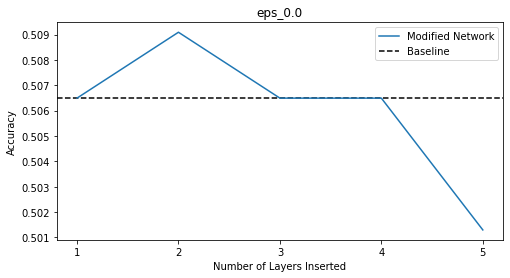

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


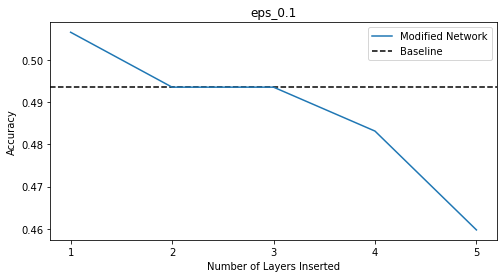

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


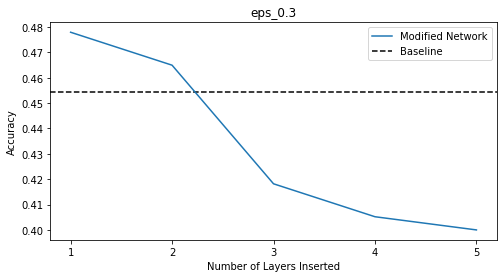

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


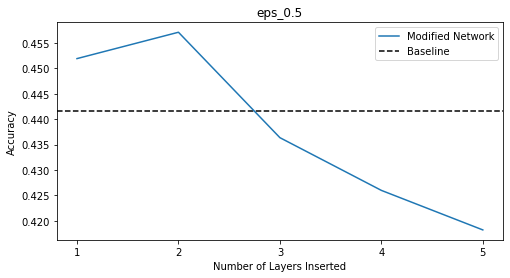

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


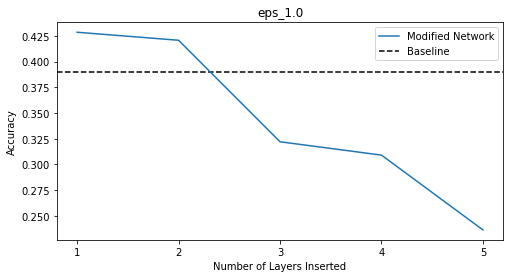

In [ ]:
out_dir = '/content/drive/MyDrive/DeepLearningFinal/results/Multi-layer Insertion Test/'

for eps in eps_list:
  plt.figure(figsize = (8,4))
  accs = []
  for acc in acc_save[eps].values():
    accs.append(acc)
    
  plt.plot(np.arange(1,6), accs[1:])
  xmin, xmx = plt.xlim()
  plt.hlines(accs[0], xmin, xmx, linestyles='dashed')
  plt.xlabel('Number of Layers Inserted')
  plt.ylabel('Accuracy')
  plt.title(eps)
  plt.xlim(xmin, xmx)
  plt.xticks(np.arange(1,6))
  plt.legend(['Modified Network', 'Baseline'])
  plt.savefig(out_dir+'FGSM_ACC_'+eps+'.eps', format='eps')
  plt.show()

# DeepFool

## Test Accuracy of Each Single Layer Insertion

In [ ]:
## ACCURACY TESTING LOOP WITHOUT EPSILONS
N_denoise = 50
TestingLoops = 5
noise_sigma = 100

dir = "/content/drive/MyDrive/DeepLearning/DeepLearningFinal/adversarial_images/deepfoolL2/"
dir =  "/content/drive/MyDrive/DeepLearningFinal/adversarial_images/deepfoolL2/"

#Initialize epselon dictionary
acc_save = {}
#Get directory
select_dir = dir
#Import Images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  select_dir,
  seed = 123,
  shuffle=True,
  image_size=(224, 224),
  batch_size=1)
class_names = val_ds.class_names

# extract images and labels from validation set and convert human-readable labels
# to ImageNet class IDs
images, labels = [], []
class_ids = {'bikes': 671, 'ships': 510}
for img, label in val_ds:
  class_id = class_ids[class_names[int(label)]]
  labels.append(class_id)
  images.append(img)

#Iterate over the models we inserted the layers in 
for ii, mdl in enumerate(models_list):
  #Count the number of correct predictions
  correct_prediction = []
  #Run testing a couple times on the same set of images so we average out some of the randomness
  for loop in range(TestingLoops):
    #Loop over images
    for idx, im in enumerate(images):
      L = len(mdl)
      inter = im
      #Loop over models
      for i, block in enumerate(mdl):
        inter = block(inter)
        if i != L-1:
          #Costum layer insertion:

          shp = inter.shape
          intermediate = inter.numpy()
          inter = denoise_all_channels(intermediate, shp)
        else:
          out = np.argmax(inter)
      correct_prediction.append(labels[idx] == int(out))


  #Once all the images are out, calculate the percent accuracy:
  acc_save[str(ii)] = np.mean(correct_prediction)
  ii +=1

Found 71 files belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


## Save and Plot Results

In [ ]:
#Save Accuracy to files
with open('/content/drive/MyDrive/DeepLearningFinal/results/deepfool_accuracy.txt','a') as file:
  file.write("Denoise type: All \n")
  file.write("Testing Loops: " + str(TestingLoops) + "\n")
  file.write("N_denoise: " + str(N_denoise) + "\n")
  file.write("Noise_sigma: " + str(noise_sigma) + "\n")
  for model_name,acc in acc_save.items():
    file.write(model_name + " " + str(acc) + "\n")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


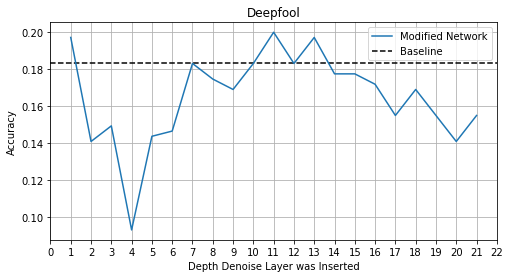

In [ ]:
# Plot accuracies
layer_nums = np.array(model_insert_positions[1:])
#out_dir = '/content/drive/MyDrive/DeepLearning/DeepLearningFinal/results/'
out_dir = '/content/drive/MyDrive/DeepLearningFinal/results/'

plt.figure(figsize = (8,4))
accs = []
for acc in acc_save.values():
  accs.append(acc)
  
plt.plot(layer_nums, accs[1:])
xmin, xmx = plt.xlim()
plt.hlines(accs[0], xmin, xmx, linestyles='dashed')
plt.xlabel('Depth Denoise Layer was Inserted')
plt.ylabel('Accuracy')
plt.title("Deepfool")
plt.xlim(xmin, xmx)
plt.xticks(np.arange(xmin,xmx+1))
plt.legend(['Modified Network', 'Baseline'])
plt.grid()
plt.savefig(out_dir+'DeepFool_ACC_denoise_all_grid.eps', format='eps')
plt.show()

## Test Accuracy of Best Multi Layer Insertion

In [ ]:
# Load accuracies from results file
layer_cnt = 21
with open('/content/drive/MyDrive/DeepLearningFinal/results/DeepFool_all_layer_acc.txt','r') as file1:
  layer_accs = {}
  for ii in range(0,layer_cnt+1):
    line = file1.readline()
    layer_num = int(line.split(' ')[0])
    acc = (float(line.split(' ')[1]))
    layer_accs[layer_num] = acc

In [ ]:
# get list of layers in desc order of acc
best_layers = {}
baseline = layer_accs[0]
# remove baseline
layer_accs = {key:layer_accs[key] for key in range(1,22)}
# sort layers by acc
sorted_layer_accs = sorted(layer_accs.items(), key =lambda x: x[1],reverse=True)
sorted_layer_nums = []
for layer_num,acc in sorted_layer_accs:
  sorted_layer_nums.append(layer_num)

In [ ]:
# Create a list of models to test

# max number of layers to insert
layer_insertion_cap = 5
models_list = {}
model_insert_positions = []
for ii in range(0,layer_insertion_cap+1):
  selected_layers = sorted_layer_nums[0:ii]
  model_insert_positions.append(selected_layers)
model_insert_names = []
for positions in model_insert_positions:
  model_insert_names.append([vgg_names[i] for i in positions])
models_list = []
for lst in model_insert_names:
  models_list.append(split_model(vgg, lst))


In [ ]:
## ACCURACY TESTING LOOP
N_denoise = 50
TestingLoops = 5
noise_sigma = 100

# dir = "/content/drive/MyDrive/DeepLearning/DeepLearningFinal/adversarial_images/deepfoolL2/"
dir =  "/content/drive/MyDrive/DeepLearningFinal/adversarial_images/deepfoolL2/"

#Initialize epselon dictionary
acc_save = {}
#Get directory
select_dir = dir
#Import Images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  select_dir,
  seed = 123,
  shuffle=True,
  image_size=(224, 224),
  batch_size=1)
class_names = val_ds.class_names

# extract images and labels from validation set and convert human-readable labels
# to ImageNet class IDs
images, labels = [], []
class_ids = {'bikes': 671, 'ships': 510}
for img, label in val_ds:
  class_id = class_ids[class_names[int(label)]]
  labels.append(class_id)
  images.append(img)

#Iterate over the models we inserted the layers in 
for ii, mdl in enumerate(models_list):
  #Count the number of correct predictions
  correct_prediction = []
  #Run testing a couple times on the same set of images so we average out some of the randomness
  for loop in range(TestingLoops):
    #Loop over images
    for idx, im in enumerate(images):
      L = len(mdl)
      inter = im
      #Loop over models
      for i, block in enumerate(mdl):
        inter = block(inter)
        if i != L-1:
          #Costum layer insertion:

          shp = inter.shape
          intermediate = inter.numpy()
          inter = denoise_all_channels(intermediate, shp)
        else:
          out = np.argmax(inter)
      correct_prediction.append(labels[idx] == int(out))


  #Once all the images are out, calculate the percent accuracy:
  acc_save[str(ii)] = np.mean(correct_prediction)
  ii +=1

Found 71 files belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [ ]:
#Save Accuracy to files
with open('/content/drive/MyDrive/DeepLearningFinal/results/deepfool_accuracy.txt','a') as file:
  file.write("Multi-layer insertion\n")
  file.write("Denoise type: All \n")
  file.write("Testing Loops: " + str(TestingLoops) + "\n")
  file.write("N_denoise: " + str(N_denoise) + "\n")
  file.write("Noise_sigma: " + str(noise_sigma) + "\n")
  for model_name,acc in acc_save.items():
    file.write(model_name + " " + str(acc) + "\n")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


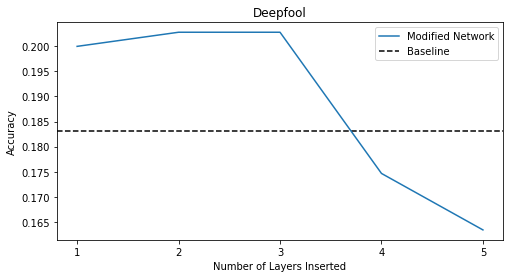

In [ ]:
# Plot accuracies

#out_dir = '/content/drive/MyDrive/DeepLearning/DeepLearningFinal/results/'
out_dir = '/content/drive/MyDrive/DeepLearningFinal/results/Multi-layer Insertion Test/'

plt.figure(figsize = (8,4))
accs = []
for acc in acc_save.values():
  accs.append(acc)
plt.plot(np.arange(1,6), accs[1:])
xmin, xmx = plt.xlim()
plt.hlines(accs[0], xmin, xmx, linestyles='dashed')
plt.xlabel('Number of Layers Inserted')
plt.ylabel('Accuracy')
plt.title("Deepfool")
plt.xlim(xmin, xmx)
plt.xticks(np.arange(1,6))
plt.legend(['Modified Network', 'Baseline'])
plt.savefig(out_dir+'DeepFool_ACC_multi-layer.eps', format='eps')
plt.show()